In [4]:
import joblib

liste = joblib.load (r"colonnes_home_loan.joblib")

trucs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

def data_to_string(labels,data):

    reponse =""

    for label,chiffre in zip (labels,data):

        reponse+=label+"="+str(chiffre)+"&"

    return reponse

data_to_string(liste,trucs)

'AMT_INCOME_TOTAL=1&AMT_CREDIT=2&AMT_GOODS_PRICE=3&YEARS_EMPLOYED=4&nb_credit=5&jour_dernier_credit=6&montant_credits_total=7&dette_due_actuelle_total=8&demande_credit_med=9&credit_accord_med=10&valeur_biens_med=11&accord_pret_moy=12&duree_credit_med=13&retard_payement_total=14&Somme_non_remboursee_total=15&Age=16&not_ext=17&'

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
pd.set_option ('display.max_columns', None)

In [6]:
df = pd.read_csv ("data_save.csv",index_col=0)

#df = df.loc[~(df.isna().sum(axis=1).sort_values(ascending=False)>19)]

df.isna().sum()

TARGET                             0
FLAG_OWN_CAR                       0
OWN_CAR_AGE                        0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
CNT_FAM_MEMBERS                    2
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_GOODS_PRICE                  278
DAYS_EMPLOYED                      0
EXT_SOURCE_1                  173378
EXT_SOURCE_2                     660
EXT_SOURCE_3                   60965
nb_credit                      44020
nb_credit_actifs               44020
jour_dernier_credit            44020
jours_retard_credit_cb         44020
max_impaye                    123625
montant_credits_total          44020
nb_prolongation_credit_max     44020
dette_due_actuelle_total       51380
demande_credit_med             16454
credit_accordé_med             16454
valeur_biens_med               17429
CODE_REJECT_REASON_med         16454
fidélité_client                16454
accord_prêt_moy                16454
d

In [7]:
# première tentative de scoring : valeur étalon pour la complétion des données par la suite
df0 = df.copy().dropna()
print (f'il reste {df0.shape[0]} lignes, travail sur {df0.shape[0]/df.shape[0]*100:.0f}% des clients')

il reste 74524 lignes, travail sur 24% des clients


from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(sparse=False)

code_reject = pd.DataFrame(ohe.fit_transform (df0.CODE_REJECT_REASON_med.to_numpy().reshape(-1, 1)),columns=ohe.categories_)

df0 = df0.reset_index().join (code_reject)
df0.drop(["CODE_REJECT_REASON_med"],axis=1,inplace=True)
df0 = df0.set_index ("SK_ID_CURR")
df0.head()

from sklearn.model_selection import train_test_split


X,x,Y,y = train_test_split (df0.drop (["TARGET"],axis=1),df0.TARGET)

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE


estimator = RandomForestClassifier(n_jobs=-1)

rfe = RFE(estimator=estimator,n_features_to_select=10)

rfe.fit (X,Y)

X[X.columns[rfe.support_]]

estimator.fit (X[X.columns[rfe.support_]],Y)

estimator.score (x[X.columns[rfe.support_]],y)

## complétion

In [8]:
# moyenne des notes ext

notesadd = df.EXT_SOURCE_1.fillna(0)+df.EXT_SOURCE_2.fillna(0)+df.EXT_SOURCE_3.fillna(0)
nbnotes = df[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]].notna().sum(axis=1)

note_final = notesadd / nbnotes 

df["not_ext"] = note_final
df = df.drop (["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"],axis=1)

df.not_ext.isna().sum()

172

<AxesSubplot: xlabel='AMT_CREDIT', ylabel='AMT_GOODS_PRICE'>

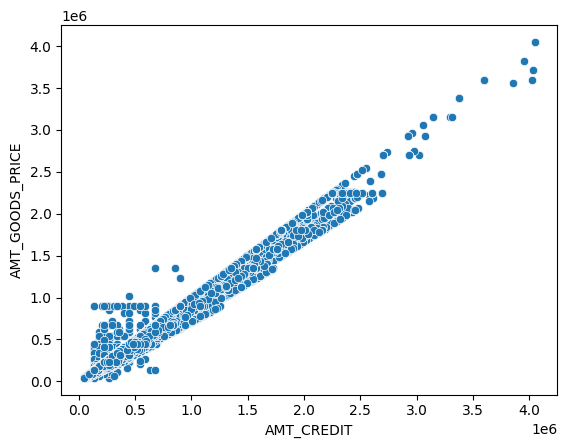

In [9]:
# retrouver les good prices de certaines clients, bonne corrélation avec le prix (a l'exception des petits achats)

sns.scatterplot (x=df.AMT_CREDIT,y=df.AMT_GOODS_PRICE)

In [10]:
# création d'intervales de crédits pour attribuer les prix des biens non connus

creditcut = pd.qcut(df.AMT_CREDIT,q=45)

pds = pd.concat ([creditcut,df.AMT_GOODS_PRICE],axis=1)

pds = pds.groupby ("AMT_CREDIT")["AMT_GOODS_PRICE"].mean()

pds.head()

AMT_CREDIT
(44999.999, 101880.0]     71799.717127
(101880.0, 135000.0]     118349.714119
(135000.0, 157500.0]     136835.528361
(157500.0, 180000.0]     166907.444667
(180000.0, 188460.0]     150716.096439
Name: AMT_GOODS_PRICE, dtype: float64

In [11]:
amt_goodna = df[df.AMT_GOODS_PRICE.isna()]

for index,row in amt_goodna.iterrows():
    for credit,goodmoy in pds.items():

        if row.AMT_CREDIT in credit:
            df.loc[index,"AMT_GOODS_PRICE"] = goodmoy

df.AMT_GOODS_PRICE.isna().sum()

0

In [12]:
df.nb_credit.fillna (0,inplace=True)
df.nb_credit_actifs.fillna (0,inplace=True)
df.jour_dernier_credit.fillna(0,inplace=True)
df.jours_retard_credit_cb.fillna(0,inplace=True)
df.montant_credits_total.fillna(0,inplace=True)
df.nb_prolongation_credit_max.fillna(0,inplace=True)
df.loc[df.iloc[:,18:27].isna().all(axis=1),"dette_due_actuelle_total":"Somme_non_remboursée_total"] = 0
df.max_impaye.fillna(0,inplace=True)
df.dette_due_actuelle_total.fillna(0,inplace=True)
df.loc[df.CODE_REJECT_REASON_med==0,"CODE_REJECT_REASON_med"] = "NO"

df.isna().sum()



TARGET                           0
FLAG_OWN_CAR                     0
OWN_CAR_AGE                      0
FLAG_OWN_REALTY                  0
CNT_CHILDREN                     0
CNT_FAM_MEMBERS                  2
AMT_INCOME_TOTAL                 0
AMT_CREDIT                       0
AMT_GOODS_PRICE                  0
DAYS_EMPLOYED                    0
nb_credit                        0
nb_credit_actifs                 0
jour_dernier_credit              0
jours_retard_credit_cb           0
max_impaye                       0
montant_credits_total            0
nb_prolongation_credit_max       0
dette_due_actuelle_total         0
demande_credit_med            1512
credit_accordé_med            1512
valeur_biens_med              2487
CODE_REJECT_REASON_med        1512
fidélité_client               1512
accord_prêt_moy               1512
durée_credit_med              1927
taux_interet_cat              1512
retard_payement_total          926
Somme_non_remboursée_total     926
Age                 

In [13]:
df[abs(df.DAYS_EMPLOYED) >1000]['DAYS_EMPLOYED']

SK_ID_CURR
100011   -1000.665753
100015   -1000.665753
100027   -1000.665753
100045   -1000.665753
100050   -1000.665753
             ...     
456209   -1000.665753
456227   -1000.665753
456231   -1000.665753
456249   -1000.665753
456252   -1000.665753
Name: DAYS_EMPLOYED, Length: 55374, dtype: float64

In [14]:
df.loc[abs(df.DAYS_EMPLOYED) >1000,'DAYS_EMPLOYED'] = df.DAYS_EMPLOYED.mean()

In [15]:
df.to_csv ("final_tab_train.csv")

In [16]:
# nouvel essai

df1 = df.copy().dropna()

df1.shape[0]/df.shape[0]

0.9885272396759791

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
 

ohe = OneHotEncoder(sparse=False)

code_reject = pd.DataFrame(ohe.fit_transform (df1.CODE_REJECT_REASON_med.to_numpy().reshape(-1, 1)),columns=list(ohe.get_feature_names_out()))

df1 = df1.reset_index().join (code_reject)
df1.drop(["CODE_REJECT_REASON_med"],axis=1,inplace=True)
df1 = df1.set_index ("SK_ID_CURR")
df1.loc[:,(df1.max()>1) | (df1.min()<-1)] = StandardScaler().fit_transform(df1.loc[:,(df1.max()>1) | (df1.min()<-1)])
df1.head()

f:\programmes\env\mlflow\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,TARGET,FLAG_OWN_CAR,OWN_CAR_AGE,FLAG_OWN_REALTY,CNT_CHILDREN,CNT_FAM_MEMBERS,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,nb_credit,nb_credit_actifs,jour_dernier_credit,jours_retard_credit_cb,max_impaye,montant_credits_total,nb_prolongation_credit_max,dette_due_actuelle_total,demande_credit_med,credit_accordé_med,valeur_biens_med,fidélité_client,accord_prêt_moy,durée_credit_med,taux_interet_cat,retard_payement_total,Somme_non_remboursée_total,Age,not_ext,x0_CLIENT,x0_HC,x0_LIMIT,x0_NO,x0_SCO,x0_SCOFR,x0_SYSTEM,x0_VERIF,x0_XAP,x0_XNA
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,1,-0.476564,0,-0.577604,-1.265200,0.141492,-0.477522,-0.506276,0.398257,0.717554,0.131036,0.600946,-0.049633,-0.001881,-0.209399,-0.153195,-0.137744,0.495894,0.389209,0.115201,-1.812189,1.000000,1.177621,-0.334281,-0.114667,0.035637,-1.502971,0.161787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100003,0,1,-0.476564,1,-0.577604,-0.167718,0.424825,1.725743,1.601326,0.419858,-0.171234,-0.422952,-0.357219,-0.049633,-0.019581,-0.169951,-0.153195,-0.343893,1.613438,1.501178,0.953025,0.598736,1.000000,-0.114546,0.681581,0.320008,0.035637,0.168917,0.466757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100004,0,0,2.418895,0,-0.577604,-1.265200,-0.425173,-1.152229,-1.091044,0.382105,-0.615628,-0.976939,0.019951,-0.049633,-0.019581,-0.384443,-0.153195,-0.343893,-0.595751,-0.653035,-0.703206,-1.812189,1.000000,-0.975991,0.681581,0.644455,0.035637,0.691039,0.642739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100006,0,1,-0.476564,0,-0.577604,-0.167718,-0.141841,-0.710827,-0.652468,0.492423,-1.060022,-0.976939,0.797151,-0.049633,-0.019581,-0.433391,-0.153195,-0.343893,1.137347,0.971971,1.255532,0.598736,0.888889,0.208496,-0.334281,0.047556,0.035637,0.681654,0.650442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100007,0,1,-0.476564,0,-0.577604,-1.265200,-0.198507,-0.213195,-0.067700,0.492383,-0.837825,-0.976939,-1.391579,-0.049633,-0.019581,-0.395522,-0.153195,-0.343893,0.581908,0.512991,0.179686,0.598736,1.000000,0.208496,1.189512,0.193141,0.209853,0.893844,0.322738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:


X,x,Y,y = train_test_split (df1.drop (["TARGET"],axis=1),df1.TARGET)

In [19]:
Y.shape[0] / (2 * np.bincount(Y))

# mode balanced, équilibre de manière inversement proportielle les classes, ici 0.5 fois les clients remboursant, 6.2 fois les clients ne remboursant pas



array([0.54397372, 6.18521432])

In [20]:
print ("représentation classe 1",np.bincount(Y)[0]*0.54390883)
print ("représentation classe 2",(np.bincount(Y)[1]*6.19361587))

représentation classe 1 113979.90268831
représentation classe 2 114148.3404841


In [21]:


estimator = RandomForestClassifier(n_jobs=4,class_weight="balanced")

rfecv = RFECV(estimator,n_jobs=4,scoring='roc_auc')

rfecv.fit (X,Y)

plt.plot (rfecv.cv_results_["mean_test_score"])
rfecv.ranking_

In [ ]:
print(X.columns[rfecv.ranking_ ==1].to_list())

['FLAG_OWN_CAR', 'OWN_CAR_AGE', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'nb_credit', 'nb_credit_actifs', 'jour_dernier_credit', 'jours_retard_credit_cb', 'max_impaye', 'montant_credits_total', 'nb_prolongation_credit_max', 'dette_due_actuelle_total', 'demande_credit_med', 'credit_accordé_med', 'valeur_biens_med', 'fidélité_client', 'accord_prêt_moy', 'durée_credit_med', 'taux_interet_cat', 'retard_payement_total', 'Somme_non_remboursée_total', 'Age', 'not_ext', 'x0_HC', 'x0_LIMIT', 'x0_XAP']


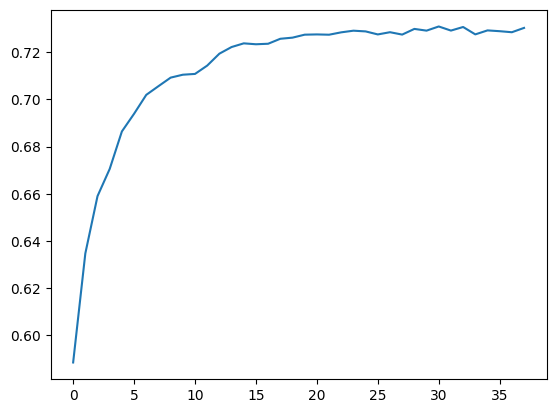

In [ ]:
plt.plot (rfecv.cv_results_["mean_test_score"])

# 17 classes

In [ ]:

from sklearn.feature_selection import RFE


estimator = RandomForestClassifier(n_jobs=-1,class_weight="balanced")

rfe = RFE(estimator=estimator,n_features_to_select=17)

rfe.fit (X,Y)

rfe_col = X[X.columns[rfe.support_]].columns

X[X.columns[rfe.support_]]

#AMT_INCOME_TOTAL	AMT_CREDIT	AMT_GOODS_PRICE	DAYS_EMPLOYED	nb_credit	jour_dernier_credit	montant_credits_total	dette_due_actuelle_total	demande_credit_med	credit_accordé_med	valeur_biens_med	accord_prêt_moy	durée_credit_med	retard_payement_total	Somme_non_remboursée_total	Age	not_ext

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,nb_credit,jour_dernier_credit,montant_credits_total,dette_due_actuelle_total,demande_credit_med,credit_accordé_med,valeur_biens_med,accord_prêt_moy,durée_credit_med,retard_payement_total,Somme_non_remboursée_total,Age,not_ext
SK_ID_CURR,,,,,,,,,,,,,,,,,
194809,-0.330729,0.587667,0.370876,0.528333,-0.171234,0.492367,-0.267195,-0.204094,-0.279309,-0.331468,-0.100335,1.0,1.177621,0.478072,0.071990,-0.490774,0.617658
208408,-0.236285,-1.152229,-1.091044,0.423425,1.606341,0.376168,-0.036365,-0.053281,-0.188899,-0.394952,-0.398189,1.0,-0.760630,0.833716,0.692381,-0.120184,0.555205
377539,-0.198507,-1.234507,-1.212871,0.413350,-0.393431,0.539989,-0.138496,0.410982,-0.141465,-0.203320,-0.362628,1.0,-0.329907,0.411519,0.035637,-1.652214,0.369738
298581,-0.236285,0.521264,0.370876,-2.128459,0.050963,0.063764,-0.208503,-0.162236,-0.452892,-0.462007,-0.596105,1.0,-0.114546,0.482232,0.035637,1.155248,0.409043
324081,-0.066285,0.853280,0.370876,0.392572,-0.393431,0.252349,-0.098978,0.132105,-0.527321,-0.572392,-0.651904,1.0,-0.114546,0.305450,0.035637,0.404913,0.520261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378143,0.235937,2.201465,2.563757,-2.128459,-0.393431,-0.536279,-0.267932,-0.343893,-0.767017,-0.784872,0.120198,1.0,-1.406713,0.432317,0.035637,1.173560,0.658776
214987,-0.425173,0.119805,-0.201709,0.395669,-0.615628,-0.079103,-0.391218,-0.303594,-0.582214,-0.616579,-0.693058,1.0,-0.437588,0.390721,0.035637,-0.294606,0.516121
328240,-0.236285,0.748197,0.980010,0.496656,-0.171234,-0.970596,-0.142836,-0.153279,-0.524083,-0.594080,-0.649477,1.0,-0.760630,-0.316407,0.035637,-1.128490,0.650194


In [ ]:
df1[rfe_col.insert(0,"TARGET")].to_csv("df_final.csv")

In [3]:
df1 = pd.read_csv("df_final.csv",index_col=0)
df1.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,nb_credit,jour_dernier_credit,montant_credits_total,dette_due_actuelle_total,demande_credit_med,credit_accordé_med,valeur_biens_med,accord_prêt_moy,durée_credit_med,retard_payement_total,Somme_non_remboursée_total,Age,not_ext
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100002,1,0.141492,-0.477522,-0.506276,0.398257,0.717554,0.600946,-0.209399,-0.137744,0.495894,0.389209,0.115201,1.000000,1.177621,-0.114667,0.035637,-1.502971,0.161787
100003,0,0.424825,1.725743,1.601326,0.419858,-0.171234,-0.357219,-0.169951,-0.343893,1.613438,1.501178,0.953025,1.000000,-0.114546,0.320008,0.035637,0.168917,0.466757
100004,0,-0.425173,-1.152229,-1.091044,0.382105,-0.615628,0.019951,-0.384443,-0.343893,-0.595751,-0.653035,-0.703206,1.000000,-0.975991,0.644455,0.035637,0.691039,0.642739
100006,0,-0.141841,-0.710827,-0.652468,0.492423,-1.060022,0.797151,-0.433391,-0.343893,1.137347,0.971971,1.255532,0.888889,0.208496,0.047556,0.035637,0.681654,0.650442
100007,0,-0.198507,-0.213195,-0.067700,0.492383,-0.837825,-1.391579,-0.395522,-0.343893,0.581908,0.512991,0.179686,1.000000,0.208496,0.193141,0.209853,0.893844,0.322738


In [46]:
X,x,Y,y = train_test_split(df1.drop("TARGET",1), df1.TARGET)
Y.value_counts()

C:\Users\Lrenard\AppData\Local\Temp\ipykernel_21388\2476299735.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X,x,Y,y = train_test_split(df1.drop("TARGET",1), df1.TARGET)


0    209579
1     18408
Name: TARGET, dtype: int64

In [59]:
from sklearn.linear_model import LogisticRegression


start =time.time()

parametres = {"tol":np.linspace (1e-10,10,1000),
              "C": np.linspace (0.1,200,1000),



                }
lr = LogisticRegression(class_weight='balanced',solver="liblinear",tol=1e-1,C=14,intercept_scaling=15,max_iter=200)

lr.fit(X,Y)
stop = time.time()

start_pred = time.time()
y_pred = lr.predict_proba (x)
stop_pred = time.time()

print (roc_auc_score(y,y_pred[:,1]),stop-start,stop_pred-start_pred)

0.7294512612174302 0.4647679328918457 0.00600123405456543


In [61]:
y.value_counts()

0    69838
1     6158
Name: TARGET, dtype: int64

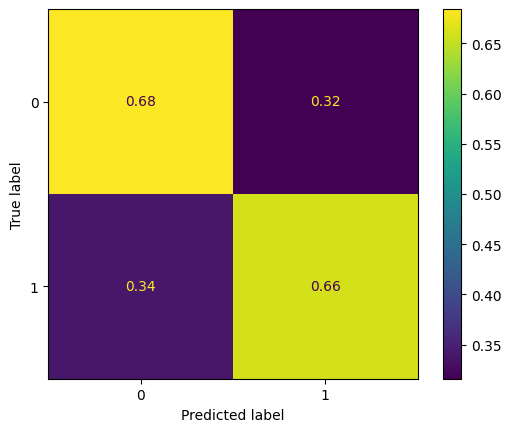

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


conf = confusion_matrix (y,lr.predict(x),normalize='true')
disp = ConfusionMatrixDisplay (conf)
disp.plot()

In [56]:
from sklearn.model_selection import RandomizedSearchCV

parametres = {"tol":np.linspace (0.1,10,1000),
              "C": np.linspace (0.1,200,1000),
              "intercept_scaling":  (0.1,200,1000)
             }

lr = LogisticRegression(class_weight='balanced',max_iter=500)

Rgrid = RandomizedSearchCV(lr,parametres,n_iter=1000,scoring="roc_auc",n_jobs=-1,verbose=3)
Rgrid.fit(X,Y)

pd.DataFrame (Rgrid.cv_results_).sort_values(by="mean_test_score")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_intercept_scaling,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
640,3.911449,0.066026,0.044039,0.009326,3.241441,200,0.3001,"{'tol': 3.241441441441442, 'intercept_scaling'...",0.731834,0.734717,0.721894,0.733114,0.739612,0.732234,0.005804,1000
755,3.774435,0.431980,0.046041,0.005941,4.143243,1000,0.7003,"{'tol': 4.143243243243243, 'intercept_scaling'...",0.731841,0.734716,0.721901,0.733115,0.739604,0.732235,0.005800,999
77,3.691755,0.307104,0.052046,0.005067,3.736937,0.1,0.9004,"{'tol': 3.7369369369369374, 'intercept_scaling...",0.731840,0.734716,0.721905,0.733113,0.739610,0.732236,0.005800,998
613,3.945571,0.205701,0.065862,0.009670,4.153153,200,1.300601,"{'tol': 4.153153153153153, 'intercept_scaling'...",0.731842,0.734714,0.721905,0.733113,0.739608,0.732237,0.005799,997
462,3.489137,0.432507,0.045946,0.009380,4.658559,200,156.978478,"{'tol': 4.658558558558559, 'intercept_scaling'...",0.731844,0.734712,0.721910,0.733114,0.739603,0.732237,0.005796,996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,3.267886,0.160729,0.047487,0.006176,9.484685,1000,17.908909,"{'tol': 9.484684684684686, 'intercept_scaling'...",0.731851,0.734757,0.721917,0.733120,0.739599,0.732249,0.005796,5
379,3.188789,0.323152,0.045441,0.007666,9.365766,0.1,11.505706,"{'tol': 9.365765765765767, 'intercept_scaling'...",0.731850,0.734757,0.721917,0.733120,0.739602,0.732249,0.005797,4
771,3.377715,0.280166,0.046677,0.004559,9.831532,200,11.905906,"{'tol': 9.831531531531532, 'intercept_scaling'...",0.731851,0.734757,0.721917,0.733120,0.739602,0.732249,0.005797,3
196,3.039161,0.258431,0.042838,0.004172,9.623423,1000,12.306106,"{'tol': 9.623423423423423, 'intercept_scaling'...",0.731850,0.734757,0.721917,0.733120,0.739603,0.732249,0.005797,2


In [10]:
estimator = RandomForestClassifier(n_jobs=-1,class_weight="balanced",random_state=848)

start = time.time()
estimator.fit (X,Y)
stop = time.time()
start_pred = time.time()
y_pred = estimator.predict_proba (x)
stop_pred = time.time()
print (roc_auc_score(y,y_pred[:,1]),stop-start,stop_pred-start_pred)

0.7234067975167484 5.77405571937561 0.10699987411499023


In [50]:
estimator = RandomForestClassifier(n_jobs=-1,class_weight={0:0.13,1:0.87},random_state=848)
start = time.time()
estimator.fit (X,Y)
stop = time.time()
y_pred = estimator.predict_proba (x)
print (roc_auc_score(y,y_pred[:,1]),stop-start)

0.7287199824609639 5.394872188568115


In [57]:
len(y_pred)

75996

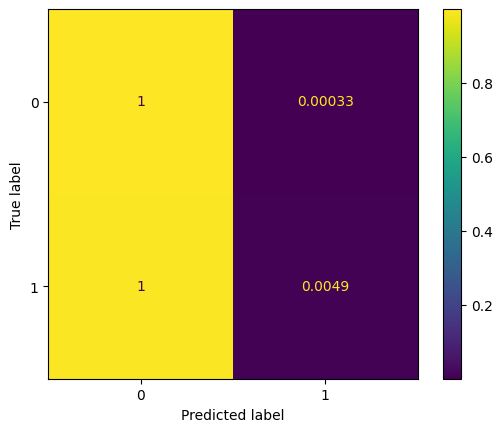

In [69]:
y_pred = estimator.predict (x)

conf = confusion_matrix (y,y_pred,normalize='true')
disp = ConfusionMatrixDisplay (conf)
disp.plot()

In [33]:
poids = np.arange (0,0.5,0.01)

class_weight = [{0:x,1:1-x} for x in poids]
tab_result = pd.DataFrame(columns=["poids","auc"])

for i,weights in enumerate(class_weight):
    estimator = RandomForestClassifier(n_jobs=-1,class_weight=weights,random_state=848)

    estimator.fit (X,Y)
    y_pred = estimator.predict_proba (x)
    tab_result = pd.concat ([tab_result,pd.DataFrame ({"poids":weights,"auc":roc_auc_score(y,y_pred[:,1])})])


tab_result.sort_values(by="auc",ascending=False)

,poids,auc
1,0.87,0.724150
0,0.13,0.724150
0,0.19,0.723330
1,0.81,0.723330
0,0.20,0.723081
...,...,...
0,0.02,0.707372
1,0.99,0.701328
0,0.01,0.701328
1,1.00,0.500000


In [11]:


alpha=[10 ** x for x in range(-10,0)]


cv_score_array=[]
train_score_array=[]

for i in alpha:
    start = time.time()
    log_clf=SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    log_clf.fit(X,Y)
    log_sig_clf = CalibratedClassifierCV(log_clf, method="sigmoid")
    log_sig_clf.fit(X,Y)

    stop = time.time()
    start_pred = time.time()

    cv_predict_y = log_sig_clf.predict_proba(x)
    stop_pred = time.time()

    print(i,roc_auc_score(y, cv_predict_y[:,1], labels=log_clf.classes_),"time",stop-start,stop_pred-start_pred)

1e-10 0.6213557253624126 time 4.596018314361572 0.02500128746032715
1e-09 0.6301432143669017 time 5.206008672714233 0.02599930763244629
1e-08 0.6687633635123253 time 7.634027719497681 0.024999618530273438
1e-07 0.6555938362841298 time 9.089315176010132 0.024999380111694336
1e-06 0.7034206396171679 time 6.317719221115112 0.024999618530273438
1e-05 0.7247455284626445 time 4.156006813049316 0.024999618530273438
0.0001 0.7271072879297572 time 2.264531135559082 0.023999691009521484
0.001 0.7258950139266607 time 1.7889297008514404 0.024001598358154297
0.01 0.6764901203390983 time 2.0207812786102295 0.025002002716064453
0.1 0.6374039832271648 time 1.4974770545959473 0.026000022888183594


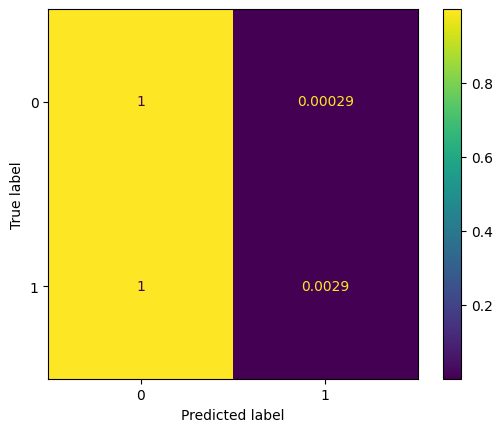

In [73]:
log_clf=SGDClassifier(alpha=0.0001, penalty='l2', loss='log_loss', random_state=42)
log_clf.fit(X,Y)
log_sig_clf = CalibratedClassifierCV(log_clf, method="sigmoid")
log_sig_clf.fit(X,Y)

y_pred = log_sig_clf.predict (x)

conf = confusion_matrix (y,y_pred,normalize='true')
disp = ConfusionMatrixDisplay (conf)
disp.plot()

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()

start = time.time()
knc.fit (X,Y)

stop = time.time()

start_pred = time.time()
predict_y = knc.predict_proba(x)
stop_pred = time.time()
print(roc_auc_score(y, predict_y[:,1]),"time",stop-start,stop_pred-start_pred)

0.5690882859861118 time 0.01799774169921875 4.635429859161377


In [37]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
                n_estimators=260,
                class_weight="balanced",
                learning_rate=0.01,
                max_depth = -1,
                num_leaves=60,
                colsample_bytree=0.313,
                subsample=0.708,
                max_bin=500,
                reg_alpha=3.664,
                reg_lambda=4.930,
                min_child_weight= 25,
                min_child_samples=100,
                verbose=-1,
                n_jobs=-1
                )
start = time.time()
lgbm.fit (X,Y)
stop = time.time()
start_pred = time.time()
y_pred = lgbm.predict_proba(x)

stop_pred = time.time()

print (roc_auc_score(y, y_pred[:,1]),stop-start,stop_pred-start_pred)

0.7514736159430895 1.2280232906341553 0.23653554916381836


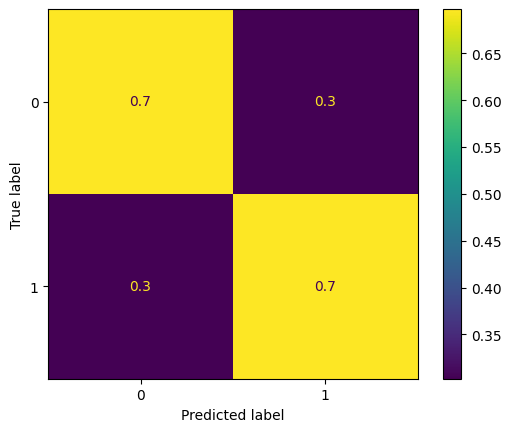

In [70]:
y_pred = lgbm.predict (x)

conf = confusion_matrix (y,y_pred,normalize='true')
disp = ConfusionMatrixDisplay (conf)
disp.plot()

100%|===================| 75931/75996 [14:12<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -0.801966, while the model output was -0.773121. If this difference is acceptable you can set check_additivity=False to disable this check.

100%|===================| 75951/75996 [14:12<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


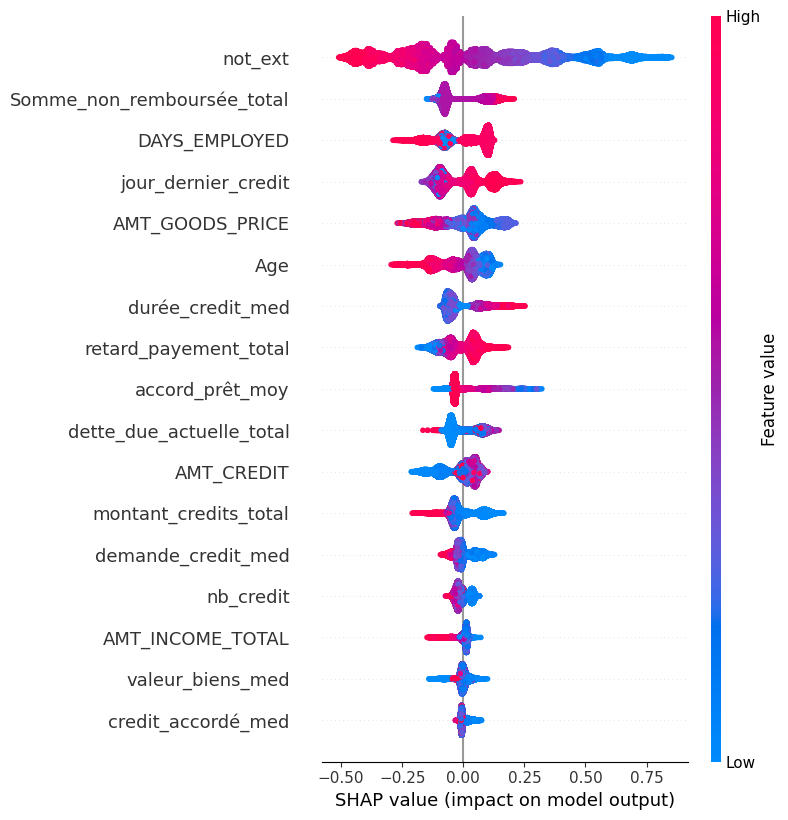

In [82]:
import shap
# Calculer l'importance des caractéristiques avec SHAP

explainer = shap.Explainer(lgbm, X)
shap_values = explainer(x,check_additivity=False)

# Visualiser les valeurs SHAP pour les caractéristiques
shap.summary_plot(shap_values, x)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,nb_credit,jour_dernier_credit,montant_credits_total,dette_due_actuelle_total,demande_credit_med,credit_accordé_med,valeur_biens_med,accord_prêt_moy,durée_credit_med,retard_payement_total,Somme_non_remboursée_total,Age,not_ext
SK_ID_CURR,,,,,,,,,,,,,,,,,
158333,0.141492,-0.984545,-0.908304,0.43107,1.161947,0.34188,0.25577,0.151233,-0.767017,-0.784872,-0.204367,0.777778,1.177621,0.251375,0.035637,1.445036,0.387551


In [96]:
shap.initjs()
single_shap_value = explainer(x.iloc[1])

shap.force_plot(single_shap_value, feature_names=x.columns)

In [95]:
y.iloc[1]

0